## Фреймворк PyTorch для разработки искусственных нейронных сетей

### Домашнее задание №7

**Урок 7. Рекурентные сети для обработки последовательностей**

Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

**Библиотеки**

In [1]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download("punkt")

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Подключение токена kaggle для загрузки датасета**

In [3]:
from google.colab import files

In [4]:
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Загрузка и распаковка датасета**

In [5]:
!kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech

twitter-sentiment-analysis-hatred-speech.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip twitter-sentiment-analysis-hatred-speech.zip

Archive:  twitter-sentiment-analysis-hatred-speech.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                
  inflating: train.csv               


**Параметры обучения**

In [7]:
max_words = 10000
max_len = 30
num_classes = 1

epochs = 20
batch_size = 512
print_batch_n = 100

In [8]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
train_df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

Разобьем обучающий датасет на тренировочную и валидационную выборки

In [10]:
X_train, X_valid = train_test_split(train_df, test_size=0.25, random_state=42)
X_train.shape, X_valid.shape

((23971, 3), (7991, 3))

In [11]:
X_train.label.value_counts()

0    22288
1     1683
Name: label, dtype: int64

In [12]:
X_valid.label.value_counts()

0    7432
1     559
Name: label, dtype: int64

Произведем предобработку датасета

In [13]:
sw = set(get_stop_words("en"))
sw

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "s

In [14]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [15]:
morpher = WordNetLemmatizer()
morpher.lemmatize('cats')

'cat'

In [16]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = [morpher.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [17]:
from tqdm import tqdm 
tqdm.pandas()

X_train.tweet = X_train.tweet.progress_apply(preprocess_text)
X_valid.tweet = X_valid.tweet.progress_apply(preprocess_text)

100%|██████████| 7991/7991 [00:00<00:00, 23138.24it/s]


In [18]:
train_corpus = " ".join(X_train.tweet)
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)
tokens[:15]

['weekend',
 'world',
 'really',
 'going',
 'bonkers',
 'really',
 'bad',
 'atm',
 'shooting',
 'deathstroke',
 'violence',
 'hooligan',
 'euro',
 'made',
 'night']

Отфильтруем данные и соберём в корпус N наиболее частых токенов

In [19]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [20]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
len(tokens_filtered_top)

9999

In [21]:
tokens_filtered_top[:15]

['user',
 'love',
 'day',
 'u',
 'happy',
 'amp',
 'just',
 'will',
 'time',
 'life',
 'im',
 'today',
 'like',
 'new',
 'get']

In [22]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'user': 1,
 'love': 2,
 'day': 3,
 'u': 4,
 'happy': 5,
 'amp': 6,
 'just': 7,
 'will': 8,
 'time': 9,
 'life': 10,
 'im': 11,
 'today': 12,
 'like': 13,
 'new': 14,
 'get': 15,
 'positive': 16,
 'now': 17,
 'thankful': 18,
 'father': 19,
 'good': 20,
 'make': 21,
 'people': 22,
 'bihday': 23,
 'one': 24,
 'cant': 25,
 'smile': 26,
 'see': 27,
 'go': 28,
 'can': 29,
 'dont': 30,
 'take': 31,
 'want': 32,
 'friend': 33,
 'work': 34,
 'weekend': 35,
 'healthy': 36,
 'girl': 37,
 'got': 38,
 'need': 39,
 'week': 40,
 'fun': 41,
 'summer': 42,
 'family': 43,
 'way': 44,
 'friday': 45,
 'great': 46,
 'best': 47,
 '2': 48,
 'beautiful': 49,
 'bull': 50,
 'going': 51,
 'know': 52,
 'year': 53,
 'wait': 54,
 'first': 55,
 'really': 56,
 'thing': 57,
 'back': 58,
 'world': 59,
 'music': 60,
 'morning': 61,
 'affirmation': 62,
 'home': 63,
 'come': 64,
 'look': 65,
 'dad': 66,
 'think': 67,
 'tomorrow': 68,
 'feel': 69,
 'cute': 70,
 'orlando': 71,
 'never': 72,
 'fathersday': 73,
 'sad': 74,
 

In [23]:
def text_to_sequence(text, maxlen):
    
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    
    return result[-maxlen:] + padding

In [24]:
%%time

x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train.tweet])
x_val = np.asarray([text_to_sequence(text, max_len) for text in X_valid.tweet])

x_train.shape, x_val.shape

CPU times: user 3.95 s, sys: 29.2 ms, total: 3.97 s
Wall time: 4.05 s


((23971, 30), (7991, 30))

In [25]:
train_df.tweet.iloc[0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [26]:
x_train[0]

array([35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

Создадим архитектуру сети

In [27]:
class GRU_Twitter(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

Создадим датасет и обернем его даталоадером

In [28]:
class Data_Twitter(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long() 
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [29]:
train_dataset = Data_Twitter(x_train, X_train.label.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Data_Twitter(x_val, X_valid.label.values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

Проверим корректность созданного

In [30]:
train_loader.sampler

In [31]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 30])
torch.Size([512])
tensor(0)


In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [33]:
model = GRU_Twitter(max_words).to(device)

Выведем параметры модели, а также зададим оптимизатор и ошибку обучения

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [35]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

GRU_Twitter(
  (embeddings): Embedding(10000, 128, padding_idx=0)
  (gru): GRU(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 1478273


Посчитаем метрику f1_score из-за сильного дисбаланса классов

In [36]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import torchmetrics

In [38]:
train_f1_score = torchmetrics.F1Score(task='binary').to(device)
test_f1_score = torchmetrics.F1Score(task='binary').to(device)

**Начнем процесс обучения**

In [39]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right, all_f1_score_train = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        train_f1_score(outputs.squeeze(), labels)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        all_f1_score_train += train_f1_score.compute().item()
        
    # выводим статистику о процессе обучения (переводим модель в валидацию)
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. \n' \
            f'Train: Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}, ' \
            f'f1_score_train: {all_f1_score_train / (i+1):.3f}, ')

    
    running_loss, running_items, running_right, all_f1_score_train = 0.0, 0.0, 0.0, 0.0
    train_f1_score.reset()
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss, all_f1_score_test = 0.0, 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        
        test_outputs = model(data[0].to(device))
        test_labels = data[1].to(device)

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        test_f1_score(test_outputs.squeeze(), test_labels)
        
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
        
        all_f1_score_test += test_f1_score.compute().item()

    test_loss_history.append(test_loss.item())
    print(f'Test:  Loss: {test_loss:.3f}. Acc: {test_running_right / test_running_total:.3f},', end=' ')
    
    print(f'f1_score_test:  {all_f1_score_test / (j+1):.3f}\n')
    test_f1_score.reset()
    
    model.train()
        
print('Training is finished!')

Epoch [1/20]. Step [47/47]. 
Train: Loss: 0.253. Acc: 0.930, f1_score_train: 0.000, 
Test:  Loss: 0.052. Acc: 0.930, f1_score_test:  0.000

Epoch [2/20]. Step [47/47]. 
Train: Loss: 0.190. Acc: 0.930, f1_score_train: 0.000, 
Test:  Loss: 0.049. Acc: 0.930, f1_score_test:  0.002

Epoch [3/20]. Step [47/47]. 
Train: Loss: 0.130. Acc: 0.943, f1_score_train: 0.341, 
Test:  Loss: 0.031. Acc: 0.949, f1_score_test:  0.546

Epoch [4/20]. Step [47/47]. 
Train: Loss: 0.156. Acc: 0.955, f1_score_train: 0.576, 
Test:  Loss: 0.016. Acc: 0.952, f1_score_test:  0.567

Epoch [5/20]. Step [47/47]. 
Train: Loss: 0.120. Acc: 0.962, f1_score_train: 0.684, 
Test:  Loss: 0.024. Acc: 0.955, f1_score_test:  0.598

Epoch [6/20]. Step [47/47]. 
Train: Loss: 0.088. Acc: 0.968, f1_score_train: 0.744, 
Test:  Loss: 0.012. Acc: 0.954, f1_score_test:  0.632

Epoch [7/20]. Step [47/47]. 
Train: Loss: 0.063. Acc: 0.971, f1_score_train: 0.776, 
Test:  Loss: 0.015. Acc: 0.957, f1_score_test:  0.663

Epoch [8/20]. Step [

Визуализируем результаты

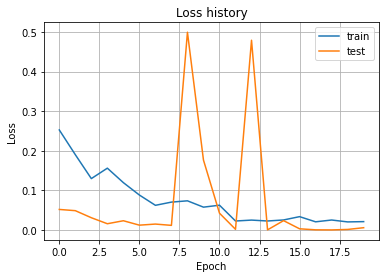

In [40]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

**Полученные выводы:**

*max_words = 1000  
max_len = 10  
epochs = 20*  

Epoch [15/15]. Step [47/47].  
Train: Loss: 0.096. Acc: 0.975, f1_score_train: 0.812,   
Test:  Loss: 0.000. Acc: 0.943, f1_score_test:  0.602

*max_words = 5000  
max_len = 20  
epochs = 15*

Epoch [15/15]. Step [47/47].   
Train: Loss: 0.042. Acc: 0.990, f1_score_train: 0.932,   
Test:  Loss: 0.000. Acc: 0.957, f1_score_test:  0.657  

*max_words = 10000  
max_len = 30  
epochs = 20*

Epoch [20/20]. Step [47/47].  
Train: Loss: 0.021. Acc: 0.995, f1_score_train: 0.966,   
Test:  Loss: 0.006. Acc: 0.959, f1_score_test:  0.662

**Выводы**

Таким образом мы можем сделать вывод о том, что увеличение словаря, а также длины при одинаковом количестве эпох.  
При этом мы можем наблюдать некоторые выбросы ошибки обучения на тестовой выборке, скорее всего обусловленные самим процессом обучения модели.
Тем не менее, мы можем сделать вывод о том, что увеличение количества и качества параметров обучения ведет к повышению качества результатов.  
Однако это одновременно вызывает значительный рост потребностей в вычислительных ресурсах(
Также с большой вероятностью улучшению качества результатов приведет усложнение арзхитектуры сети, однако это тооже потребует дополнительных ресурсов, в том числе временных, на процесс обучения.